### Main file

In [1]:
import numpy as np 
from tools.srbm import *           # !!! Importing the experimental SRBM model !!!
from tools.functions import *
import matplotlib.pyplot as plt
from brian2tools import *

date_str = str(datetime.datetime.now())[0:10]
date_time_str = str(datetime.datetime.now())[0:10]+"_"+str(datetime.datetime.now())[11:16]


/opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Some parameters for training the SRBM - the others are in paramters_main.py

t_ref = 0.004 * second
dcmt = 35
T = dcmt*t_ref
init_delay=dcmt*t_ref
delay=0*ms

n_samples = 1000

# Loading the data
data_finnegan = load_data("data_finnegan_0.1_0.05_5_200_50")

train_test_data = train_test_split_finnegan(data_finnegan, 0.9)


prototype_class_1 = 0
sub_class_1 = 1
prototype_class_2 = 0
sub_class_2 = 0

a = train_test_data[0][prototype_class_1, sub_class_1]
b = train_test_data[0][prototype_class_2, sub_class_2]
print("Hamming distance between prototype ", str(prototype_class_1), ", ", str(sub_class_1), 
      " and prototype " , str(prototype_class_2), ", ", str(sub_class_2), " : ", round(calculate_hamming_distance(a, b), 2), sep="")
print("Percent match between prototype ", str(prototype_class_1), ", ", str(sub_class_1), 
      " and prototype " , str(prototype_class_2), ", ", str(sub_class_2), " : ", round(calculate_percent_match(a, b), 2), sep="")

Data loaded from data/data_finnegan_0.1_0.05_5_200_50.npy
Hamming distance between prototype 0, 1 and prototype 0, 0 : 20.0
Percent match between prototype 0, 1 and prototype 0, 0 : 0.9


In [5]:
Ids, time_test_on, time_test_off = create_finnegan_Ids(train_test_data, off_time = 1)

NameError: name 'first_batch_train' is not defined

In [391]:
# Create the parameters for the SRBM
W, b_v, b_c, b_h = create_rbm_parameters(N_v = N_v, N_c = N_c, N_h = N_h)

# Create timepoints for classificaiton
# One timepoint for each input pattern. Starts with timepoint 1
timepoints, t_sim, time_points_dict = create_timepoints(Ids, init_delay, delay, T)

sim_time = t_sim / (dcmt*t_ref)

In [392]:
# SRBM main function

out = main(W, b_v, b_c, b_h, Id = Ids, sim_time = sim_time, t_sim = t_sim, dorun = True, n_classes = 5, 
            monitors = True, display=False) # set display to false if no lables are used 
Mh, Mv, Mc= out['Mh'], out['Mv'], out['Mc']
locals().update(out)

179.64410996437073


In [393]:
# Prepare weights and biases
W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta_parameter
Wvh=W[:N_v,:]
Wch=W[N_v:,:]
mBv = np.array(Sbv.w)*beta_parameter*tau_rec*bias_input_rate
mBh = np.array(Sbh.w)*beta_parameter*tau_rec*bias_input_rate
b_c = mBv[N_v:(N_v+N_c)]
b_v = mBv[:N_v]
b_h = mBh
mB = np.concatenate([mBv,mBh])

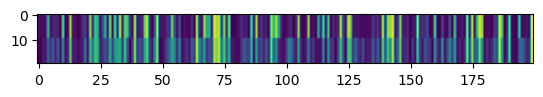

In [439]:

spike_monitor = Mv
off_time = 1

i = timepoint = 1099

t_start_stimulus = time_points_dict["T"+ str(i)+"_s"]
t_stop_stimulus = time_points_dict["T"+ str(i)+"_e"]
t_start_recover = time_points_dict["T"+ str(i+1)+"_s"]
t_stop_recover = time_points_dict["T"+ str(i+off_time)+"_e"]
orig = spike_histogram(spike_monitor, t_start=t_start_stimulus, t_stop=t_stop_stimulus).T[1]
recover = spike_histogram(spike_monitor, t_start=t_start_recover, t_stop=t_stop_recover).T[1]

imshow(np.row_stack((np.repeat(orig, 10).reshape(200, 10).T, np.repeat(recover, 10).reshape(200, 10).T)))

In [401]:
# This calculates the hamming distances and percent match for all test patterns. 
# It uses the spike moitor ant the timepoints where the stimuli are presented

off_time = 1 # How many stimulus periods are used for recoverey period histogram

hamming_distances, percent_match, originals, recovered = hamming_distances_test(Mv, time_test_on, time_points_dict, off_time=off_time)

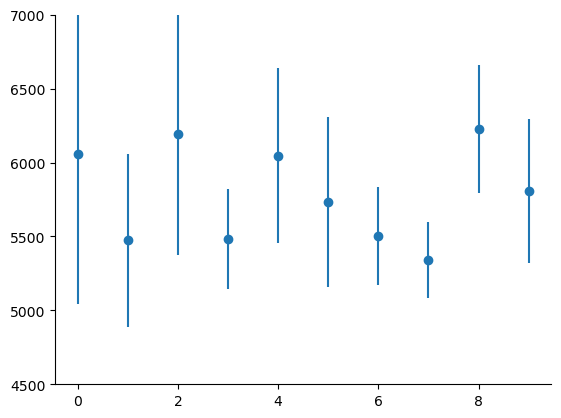

In [455]:
hd_table = np.array(hamming_distances).reshape(10, 10)
means = np.mean(hd_table, axis=0)
stds = np.std(hd_table, axis=0)

fig, ax = plt.subplots()
ax.errorbar(np.arange(10), means, stds, linestyle='None', marker='o')
ax.set_ylim([4500, 7000])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.show()